In [1]:
import os
import torch
import pathlib
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

In [2]:
n_samples = 5000

x, y = make_circles(n_samples, noise=0.03, random_state = 42)

In [3]:
len(x), len(y)

(5000, 5000)

In [4]:
x[:1]

array([[-0.75016489, -0.56389205]])

In [5]:
circles = pd.DataFrame({"X1": x[:, 0],
                       "X2": x[:, 1],
                       "label": y})

In [6]:
circles.head()

,X1,X2,label
0,-0.750165,-0.563892,0
1,0.789744,0.128750,1
2,0.747640,0.306548,1
3,-0.888250,0.489693,0
4,-0.166053,0.955303,0


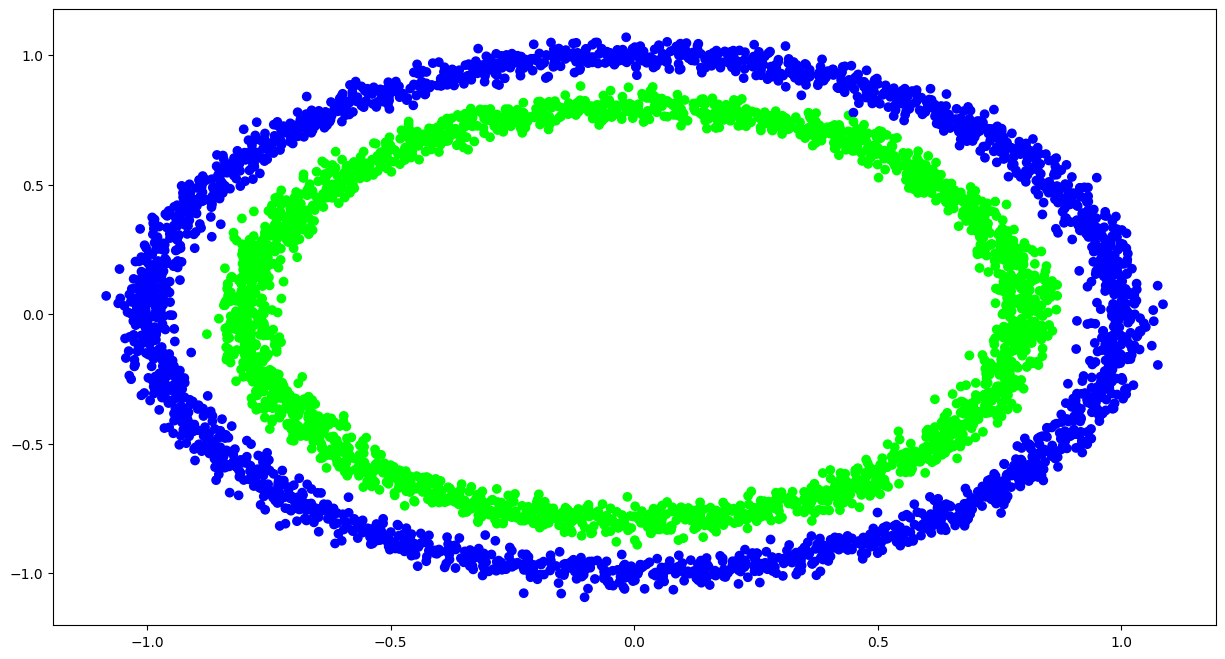

In [7]:
plt.figure(figsize=(15, 8))
plt.scatter(x=x[:, 0], y = x[:, 1], c = y , cmap = plt.cm.brg)

In [8]:
class TrainTestSplit:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def NumpyToTensor(self) -> tuple[torch.Tensor, torch.Tensor]:
        x = torch.from_numpy(self.x).type(torch.float)
        y = torch.from_numpy(self.y).type(torch.float)
        return x, y
        
    def SplitData(self) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        x_tensor, y_tensor = self.NumpyToTensor()
        x_train, x_test, y_train, y_test = train_test_split(x_tensor, y_tensor, test_size=0.3, random_state=42)
        return x_train, x_test, y_train, y_test

In [9]:
data_1 = TrainTestSplit(x, y)

In [10]:
x_train, x_test, y_train, y_test = data_1.SplitData()

In [11]:
x_train[:1]

tensor([[0.7635, 0.2612]])

In [12]:
x_test[:1]

tensor([[ 0.5886, -0.8559]])

In [13]:
y_train[:1]

tensor([1.])

In [14]:
y_test[:1]

tensor([0.])

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [16]:
x_train.shape, y_train.shape

(torch.Size([3500, 2]), torch.Size([3500]))

In [17]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # Takes in two features and upscales to 5 (Inner layers with 5 neurons)
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # Take 5 features of from previous layers and return single feature

    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 ---> layer_2 -> output

In [18]:
model_1 = CircleModelV1().to(device)
model_1 # 2 ----> 5 ----> 1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
list(model_1.parameters())

[Parameter containing:
 tensor([[ 0.4997, -0.2411],
         [-0.2013,  0.5005],
         [-0.6389,  0.2364],
         [-0.2505,  0.5512],
         [-0.1972,  0.2765]], requires_grad=True),
 Parameter containing:
 tensor([ 0.6600, -0.5059, -0.3502,  0.6852, -0.2571], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0503, -0.3403,  0.1562,  0.2397,  0.2934]], requires_grad=True),
 Parameter containing:
 tensor([-0.0440], requires_grad=True)]

In [20]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.4997, -0.2411],
                      [-0.2013,  0.5005],
                      [-0.6389,  0.2364],
                      [-0.2505,  0.5512],
                      [-0.1972,  0.2765]])),
             ('layer_1.bias',
              tensor([ 0.6600, -0.5059, -0.3502,  0.6852, -0.2571])),
             ('layer_2.weight',
              tensor([[ 0.0503, -0.3403,  0.1562,  0.2397,  0.2934]])),
             ('layer_2.bias', tensor([-0.0440]))])

In [21]:
class TrainModel:
    def __init__(self, model, x_train, x_test, y_train, y_test, epochs=50, lr=0.01):
        self.model = model
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.epochs = epochs
        self.train_loss = list()
        self.test_loss = list()
        self.train_acc = list()
        self.test_acc = list()
        self.epoch_count = list()

        self.loss_fn = nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)

    def Accuracy(self, y_true, y_pred):
        accuracy = torch.eq(y_true, y_pred).sum().item()
        acc = (accuracy / len(y_pred)) * 100
        return acc

    def Plot(self):
        plt.figure(figsize=(15, 4))
        plt.subplot(1, 2, 1)
        plt.title("Train and Test loss Curves")
        plt.plot(self.epoch_count, self.train_loss, label="Training Loss")
        plt.plot(self.epoch_count, self.test_loss, label="Testing Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

    
        plt.subplot(1, 2, 2)
        plt.title("Train and Test Accuracy Curves")
        plt.plot(self.epoch_count, self.train_acc, label="Training Accuracy")
        plt.plot(self.epoch_count, self.test_acc, label="Testing Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.show()
        
        
        
        
    def Train(self):
        # Set random seed
        torch.manual_seed(42)
        for epoch in range(1, self.epochs + 1):
            self.model.train()
            y_logits = self.model(self.x_train).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits)) # Turn logits -> pred probs -> pred lables
            # loss = self.loss_fn(torch.sigmod(y_logits), self.y_train) # For nn.BCEloss 
            loss = self.loss_fn(y_logits, self.y_train)
            accuracy = self.Accuracy(self.y_train, y_pred)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if epoch % 10 == 0:
                self.model.eval()
                with torch.inference_mode():
                    self.epoch_count.append(epoch)
                    test_logits = self.model(x_test).squeeze()
                    test_pred = torch.round(torch.sigmoid(test_logits))
                    self.train_loss.append(loss.item())
                    test_loss = self.loss_fn(test_logits, y_test)
                    self.test_loss.append(test_loss.item())
                    test_acc = self.Accuracy(y_test, test_pred)
                    self.train_acc.append(accuracy)
                    self.test_acc.append(test_acc)
                    print(f"Epoch: {epoch} | test_loss : {test_loss} | test_acc: {round(test_acc, 2)}")
                    
                    
            
            

In [22]:
model_1 = CircleModelV1()

In [23]:
train_1 = TrainModel(model=model_1, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test, epochs=200, lr=0.01)

In [24]:
train_1.Train()

Epoch: 10 | test_loss : 0.6942815184593201 | test_acc: 47.8
Epoch: 20 | test_loss : 0.6931215524673462 | test_acc: 58.53
Epoch: 30 | test_loss : 0.6935193538665771 | test_acc: 47.6
Epoch: 40 | test_loss : 0.6941920518875122 | test_acc: 48.67
Epoch: 50 | test_loss : 0.6938108801841736 | test_acc: 42.53
Epoch: 60 | test_loss : 0.6935871839523315 | test_acc: 44.27
Epoch: 70 | test_loss : 0.6936680674552917 | test_acc: 42.33
Epoch: 80 | test_loss : 0.6937349438667297 | test_acc: 42.6
Epoch: 90 | test_loss : 0.6937071681022644 | test_acc: 45.53
Epoch: 100 | test_loss : 0.6936787366867065 | test_acc: 41.73
Epoch: 110 | test_loss : 0.6936982274055481 | test_acc: 42.6
Epoch: 120 | test_loss : 0.6937035322189331 | test_acc: 44.2
Epoch: 130 | test_loss : 0.6936920285224915 | test_acc: 42.27
Epoch: 140 | test_loss : 0.6936968564987183 | test_acc: 42.67
Epoch: 150 | test_loss : 0.6936977505683899 | test_acc: 42.93
Epoch: 160 | test_loss : 0.6936957836151123 | test_acc: 42.6
Epoch: 170 | test_loss 

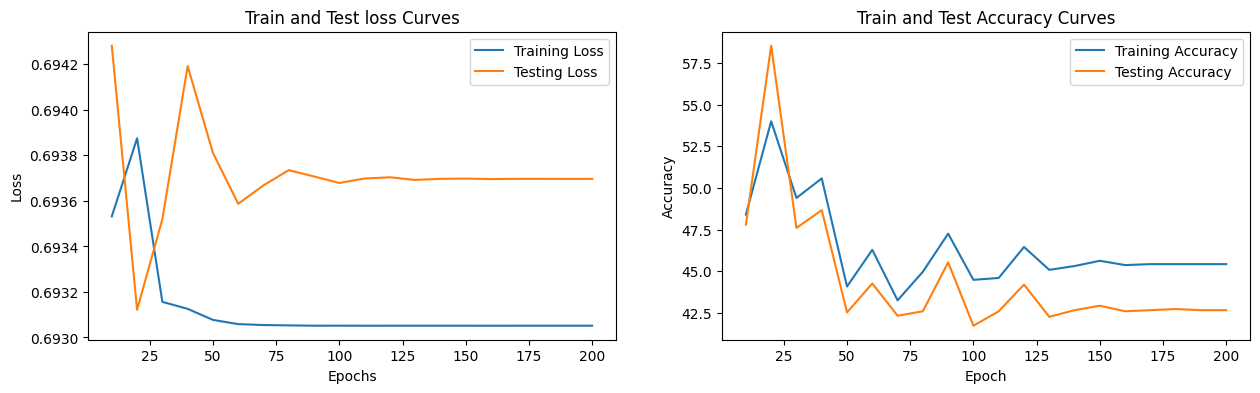

In [25]:
train_1.Plot()

In [26]:
x[:5], y[:5]

(array([[-0.75016489, -0.56389205],
        [ 0.78974434,  0.12875006],
        [ 0.74764022,  0.3065477 ],
        [-0.88825043,  0.48969296],
        [-0.16605281,  0.95530293]]),
 array([0, 1, 1, 0, 0], dtype=int64))

In [27]:
def plot_decision_boundary(model: nn.Module, x: torch.Tensor, y: torch.Tensor):
    """
    plot_decision_boundary(model: torch model | x: Tensor | y: Tensor)
    """
    x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
    y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
    x1, y1 = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101)) # shape of x1 and y1 -> 101 X 101

    x_to_predict = torch.from_numpy(np.column_stack((x1.ravel(), y1.ravel()))).float() # ravel -> ([1, 2, 3], [4, 5, 6]) -------> ([1, 2, 3, 4, 5, 6])
    # column stack = [[x1, y1]]
    
    model.eval()
    with torch.inference_mode():
        y_logits = model(x_to_predict)

    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    plt.figure(figsize=(15, 8))
    y_pred = y_pred.reshape(x1.shape).detach().numpy()
    plt.contourf(x1, y1, y_pred, cmap=plt.cm.binary_r, alpha=0.7)
    plt.scatter(x[:, 0], x[:, 1], c=y)
    plt.xlim(x1.min(), x1.max())
    plt.ylim(y1.min(), y1.max())
    plt.show()

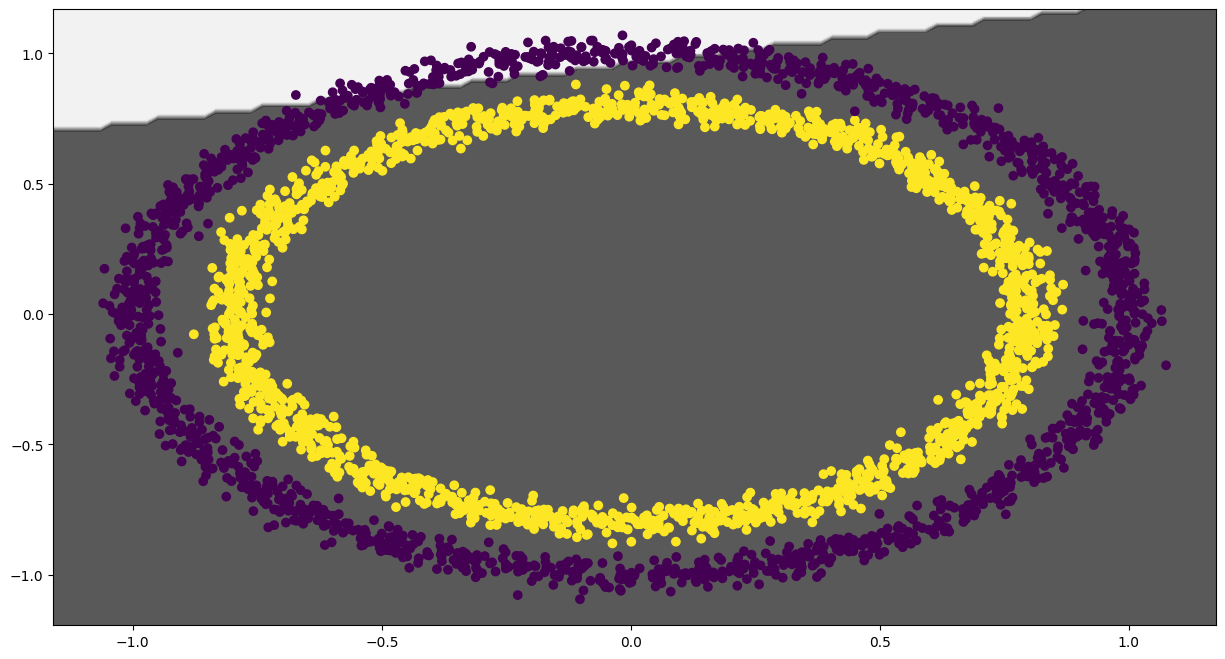

In [28]:
plot_decision_boundary(model=model_1, x=x_train, y=y_train)

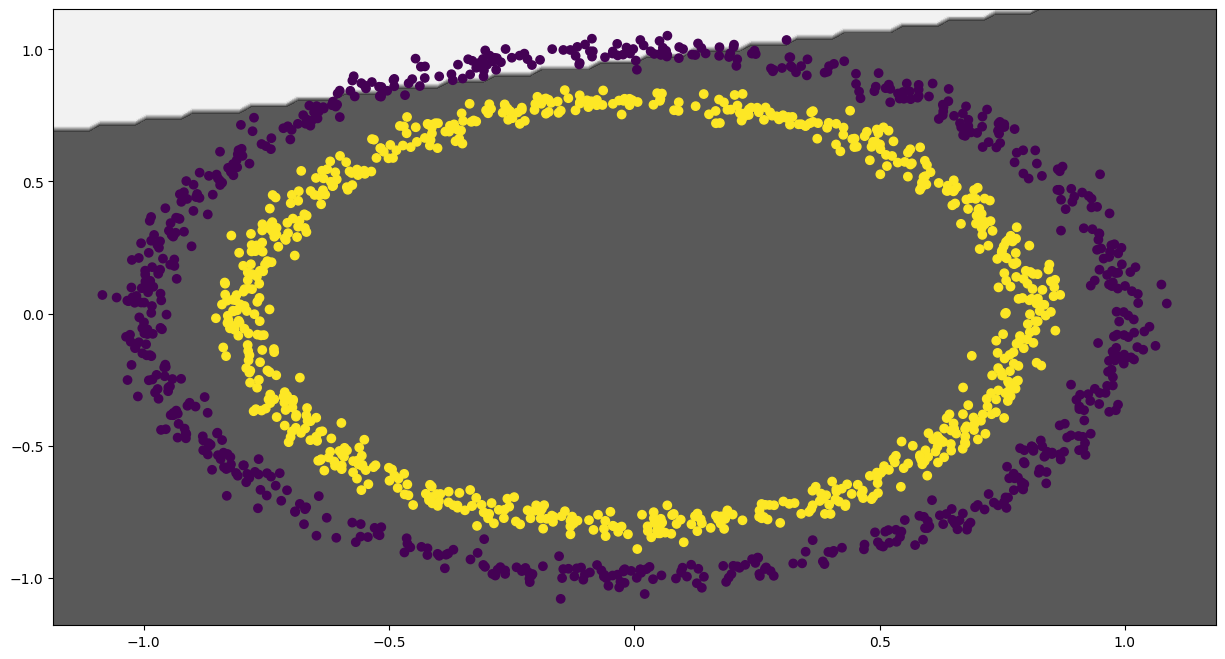

In [29]:
plot_decision_boundary(model=model_1, x=x_test, y=y_test)

In [30]:
class CirclesModelV2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=32)
        self.layer_2 = nn.Linear(in_features=32, out_features=64)
        self.layer_3 = nn.Linear(in_features=64, out_features=32)
        self.layer_4 = nn.Linear(in_features=32, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        a = self.layer_1(x)
        a = self.relu(a)
        a = self.layer_2(a)
        a = self.relu(a)
        a = self.layer_3(a)
        a = self.relu(a)
        a = self.layer_4(a)
        return a
       #return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))
        
        

In [31]:
model_2 = CirclesModelV2()

In [32]:
train_2 = TrainModel(model=model_2, x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test, epochs=100, lr=0.01)

In [33]:
train_2.Train()

Epoch: 10 | test_loss : 0.6012651920318604 | test_acc: 83.67
Epoch: 20 | test_loss : 0.16688597202301025 | test_acc: 99.6
Epoch: 30 | test_loss : 0.015850113704800606 | test_acc: 99.8
Epoch: 40 | test_loss : 0.004000307526439428 | test_acc: 99.93
Epoch: 50 | test_loss : 0.0022241135593503714 | test_acc: 100.0
Epoch: 60 | test_loss : 0.0014708110829815269 | test_acc: 100.0
Epoch: 70 | test_loss : 0.0013350869994610548 | test_acc: 100.0
Epoch: 80 | test_loss : 0.0010897726751863956 | test_acc: 100.0
Epoch: 90 | test_loss : 0.001066219643689692 | test_acc: 100.0
Epoch: 100 | test_loss : 0.0009670741274021566 | test_acc: 100.0


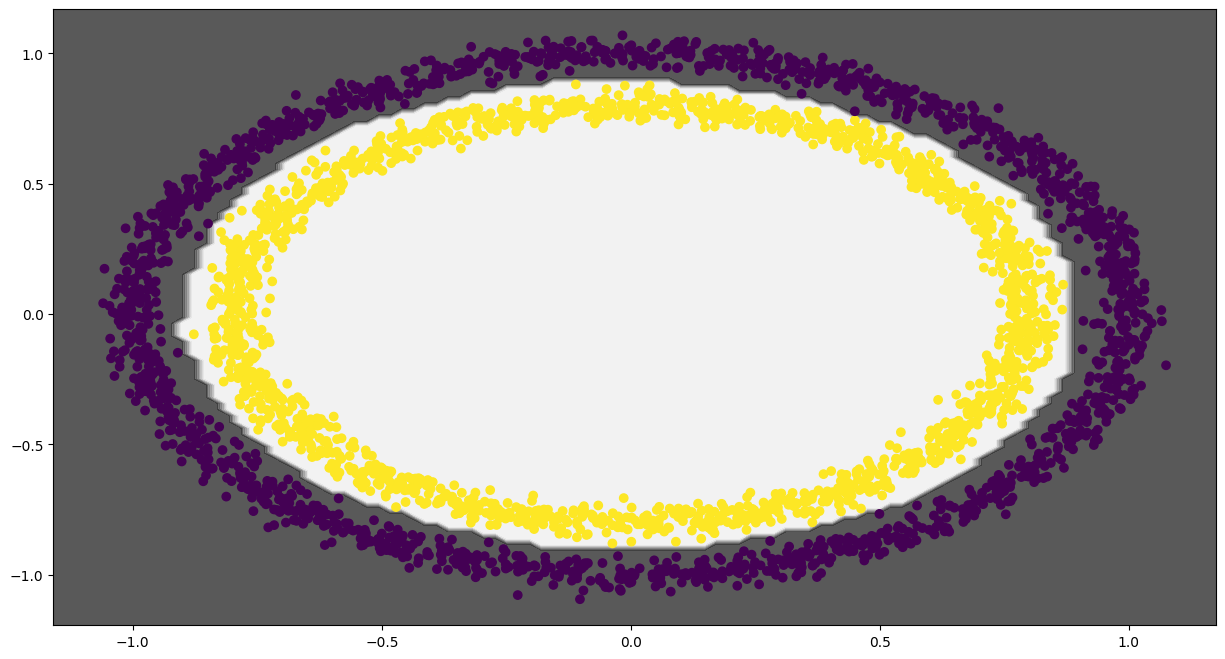

In [34]:
plot_decision_boundary(model=model_2, x=x_train, y=y_train)

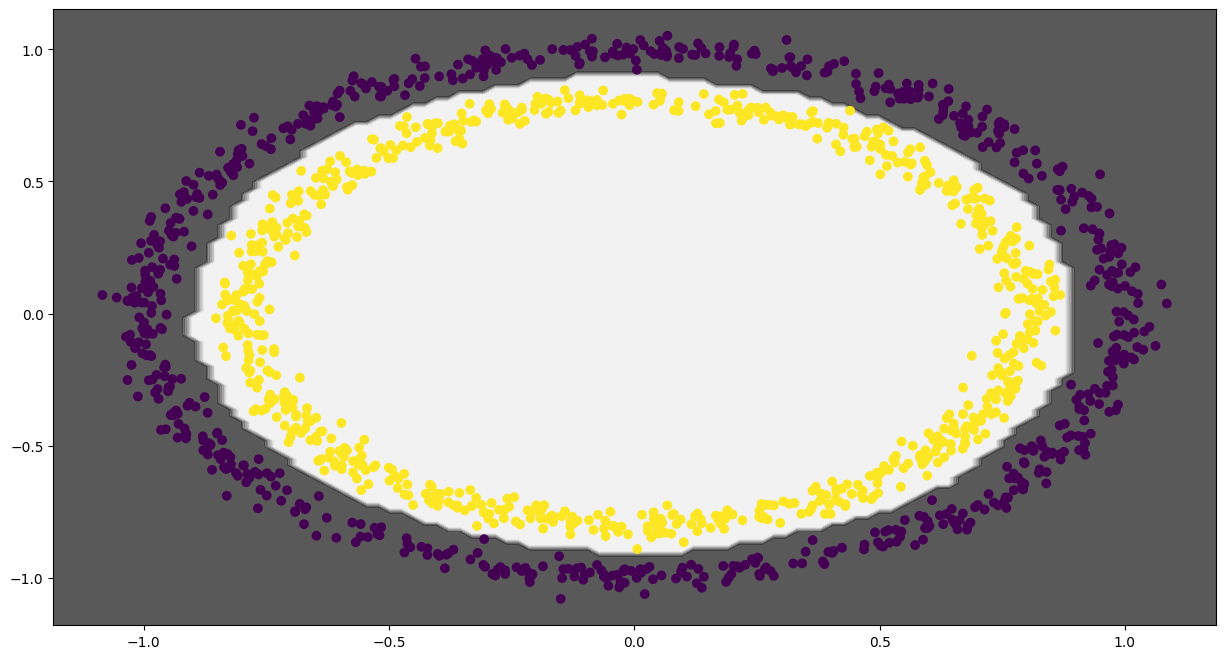

In [35]:
plot_decision_boundary(model=model_2, x=x_test, y=y_test)

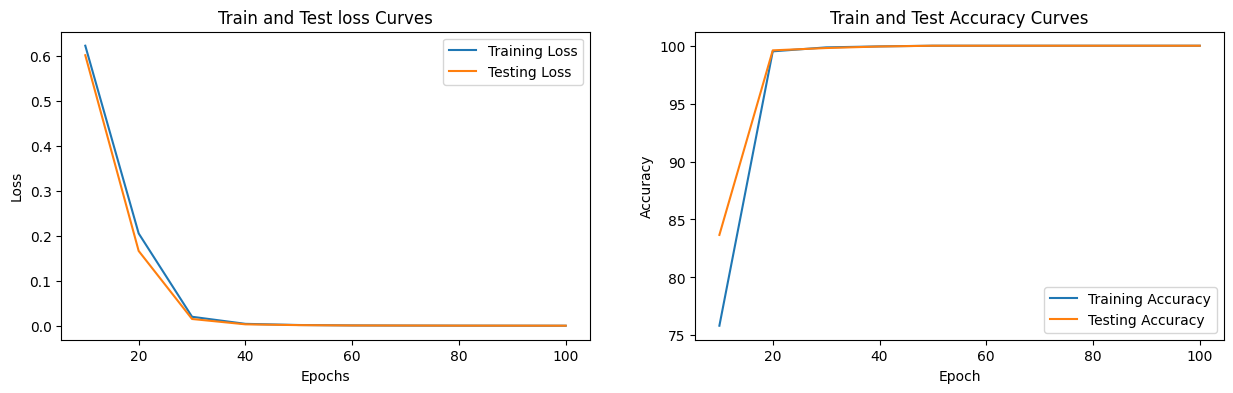

In [36]:
train_2.Plot()